Scikit-learn HistGradientBoostingRegressor() model on MDA_dataframeArthur.csv.

Time Series cross-validation: 24h delay for weather, 1 month gap between train and test sets.
MAE en RMSE can be compared to other models.

In [22]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Dataframe is loaded, datetime column is dropped in order to run model.

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\MDA_dataframeArthur.csv")
df_nd = df.drop('result_timestamp', axis=1)

The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [58]:
y = df_nd["laeq"]
X = df_nd.drop("laeq", axis="columns")

In [59]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=4320,
    max_train_size=10000,
    test_size=1000,
)

In [60]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,day,day_of_month,month,weekend,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
32951,14,4,19,8,0,52.0,15.73,32.0,437.0,0.0,0.0,-8.0,0.08,373.0,26.25,26.25,26.193,25.146406
32952,14,4,19,8,0,50.0,15.36,32.0,469.0,0.0,0.0,171.0,0.02,230.0,26.53,26.53,26.473,25.640656
32953,14,4,19,8,0,50.0,15.61,31.0,470.0,0.0,0.0,143.0,0.36,228.0,27.05,27.05,26.993,26.296341
32954,14,4,19,8,0,50.0,15.90,32.0,269.0,0.0,0.0,105.0,0.39,297.0,27.31,27.31,27.253,26.501806
32955,14,4,19,8,0,51.0,16.22,31.0,187.0,0.0,0.0,144.0,0.07,397.0,27.32,27.32,27.263,26.213027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42946,2,4,28,10,0,91.0,13.00,38.0,0.0,0.0,0.0,0.0,0.00,0.0,14.39,14.39,14.333,14.198870
42947,2,4,28,10,0,90.0,12.83,37.0,0.0,0.0,0.0,-102.0,0.00,0.0,14.39,14.39,14.333,14.185340
42948,2,4,28,10,0,90.0,12.78,38.0,0.0,0.0,0.0,0.0,0.00,0.0,14.39,14.39,14.333,14.206740
42949,2,4,28,10,0,90.0,12.78,37.0,0.0,0.0,0.0,-92.0,0.04,0.0,14.39,14.39,14.333,14.314940


In [61]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,day,day_of_month,month,weekend,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
36951,9,4,16,9,0,84.0,13.90,32.0,163.0,0.0,0.0,59.0,0.03,117.0,16.59,16.59,16.533,16.339917
36952,9,4,16,9,0,82.0,13.60,32.0,210.0,0.0,0.0,-172.0,0.02,127.0,16.78,16.78,16.723,16.384344
36953,9,4,16,9,0,79.0,13.46,31.0,165.0,0.0,0.0,98.0,0.04,134.0,17.07,17.07,17.013,16.527561
36954,9,4,16,9,0,79.0,13.63,32.0,144.0,0.0,0.0,-6.0,0.03,139.0,17.31,17.31,17.253,16.762182
36955,9,4,16,9,0,80.0,14.00,32.0,142.0,0.0,0.0,27.0,0.02,161.0,17.49,17.49,17.433,16.968314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46946,23,3,24,11,0,86.0,6.88,37.0,0.0,0.0,0.0,-81.0,0.12,0.0,9.11,9.11,9.053,9.123540
46947,23,3,24,11,0,86.0,6.92,38.0,0.0,0.0,0.0,26.0,0.03,0.0,9.17,9.17,9.113,9.154146
46948,23,3,24,11,0,85.0,6.81,37.0,0.0,0.0,0.0,36.0,0.21,0.0,9.22,9.22,9.163,9.262167
46949,23,3,24,11,0,85.0,6.78,38.0,0.0,0.0,0.0,78.0,0.13,0.0,9.22,9.22,9.163,9.232913


In [62]:
# grid search for hyperparameter tuning
param_grid = {
    'learning_rate': (0.14,0.15,0.16,0.17,0.18),
    'max_leaf_nodes': (14,15,16,17,18)}
model = HistGradientBoostingRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=4320, max_train_size=10000, n_splits=5, test_size=1000),
             estimator=HistGradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.14, 0.15, 0.16, 0.17, 0.18),
                         'max_leaf_nodes': (14, 15, 16, 17, 18)})

In [63]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.84


In [64]:
model_grid_search.predict(X.iloc[0:5])

array([41.19019993, 41.04294506, 41.04294506, 41.04294506, 41.04294506])

In [65]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.16, 'max_leaf_nodes': 16}


In [66]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.748627,0.042614,0.012200,0.000694,0.16,16,"{'learning_rate': 0.16, 'max_leaf_nodes': 16}",0.641628,0.691474,0.670985,0.684886,-0.097613,0.518272,0.308419,1
9,1.033396,0.030883,0.015551,0.002324,0.15,18,"{'learning_rate': 0.15, 'max_leaf_nodes': 18}",0.694810,0.688464,0.721101,0.681731,-0.209917,0.515238,0.362823,2
3,0.638550,0.052737,0.010176,0.001471,0.14,17,"{'learning_rate': 0.14, 'max_leaf_nodes': 17}",0.674563,0.688459,0.717512,0.666813,-0.175066,0.514456,0.345195,3
19,0.772072,0.021476,0.011570,0.000799,0.17,18,"{'learning_rate': 0.17, 'max_leaf_nodes': 18}",0.655252,0.704791,0.755451,0.664468,-0.217871,0.512418,0.366856,4
15,0.642483,0.037866,0.012367,0.000489,0.17,14,"{'learning_rate': 0.17, 'max_leaf_nodes': 14}",0.644042,0.736704,0.678711,0.666809,-0.185355,0.508182,0.348114,5


In [67]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [68]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
12,0.16,16,0.518272,0.308419,1
9,0.15,18,0.515238,0.362823,2
3,0.14,17,0.514456,0.345195,3
19,0.17,18,0.512418,0.366856,4
15,0.17,14,0.508182,0.348114,5
8,0.15,17,0.508082,0.349562,6
14,0.16,18,0.506645,0.320258,7
13,0.16,17,0.503295,0.351926,8
0,0.14,14,0.501730,0.386714,9
4,0.14,18,0.498987,0.393959,10


In [69]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,14,15,16,17,18
param_learning_rate,,,,,
0.14,0.501730,0.494678,0.489313,0.514456,0.498987
0.15,0.493455,0.472254,0.498371,0.508082,0.515238
0.16,0.497428,0.495588,0.518272,0.503295,0.506645
0.17,0.508182,0.484829,0.497155,0.479607,0.512418
0.18,0.469003,0.490928,0.482370,0.487822,0.489887


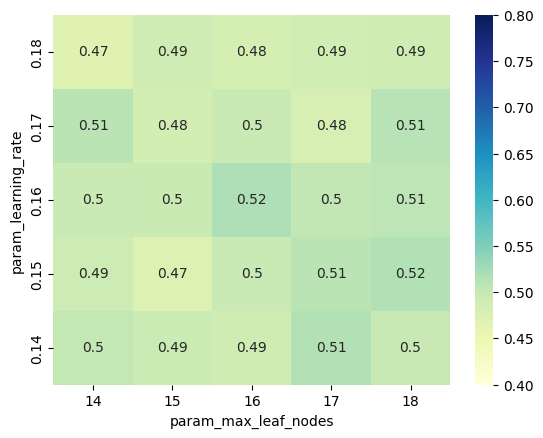

In [70]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [71]:
#run histogram gradient boosting model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = make_pipeline(HistGradientBoostingRegressor(max_leaf_nodes=16,learning_rate=0.16)).set_output(transform="pandas")

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     3.410 +/- 1.150
Root Mean Squared Error: 4.261 +/- 1.162


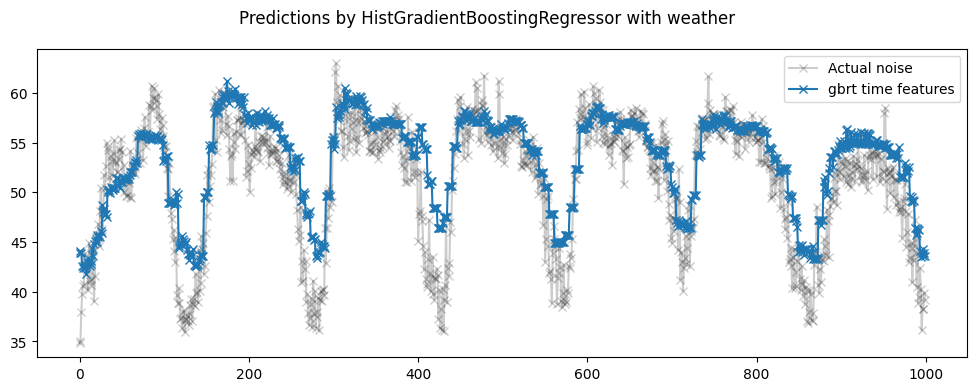

In [72]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


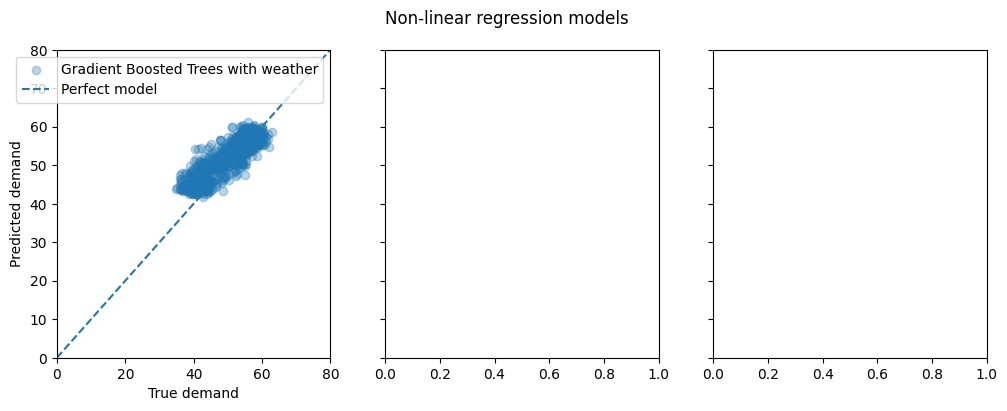

In [74]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()